# 13. Modelo de clasificacion binaria Stacked LSTM
***

### Caso de estudio #1


### Tecnicas de ajuste de los datos y modelos:

| Ingeniería de datos       | Si / No       |
| :-------                  | :------:    |
| Escalado de datos         | Si          |
| Ajuste de arquitectura         | Si          |
| Ajuste celdas de memoria            | Si          |
| Ajuste tamaño de lote  | Si          |
| Regularizacion  | Si          |
| Ajuste de pesos  | Si          |
| Sobremuestreo  | No        |

In [1]:
# librerias
import numpy as np
import math
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
import seaborn as sns


from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix,accuracy_score
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import make_scorer, accuracy_score
from plot_metric.functions import BinaryClassification
from sklearn.metrics import classification_report
from sklearn import preprocessing

import os
import h5py
from sklearn import datasets 
from keras.models import model_from_json

from numba import cuda
from pandas import DataFrame
from numpy import array
from matplotlib import pyplot

from keras import regularizers
from keras.models import load_model


Using TensorFlow backend.


In [2]:
# BINARIA funcion para generar matriz de confusion y medidas de desempeño del modelos clasificacion binarios
def model_evaluation(data_train, label_train, data_test, label_test, modelo, label_pred):
   # Medidas de desempeño del modelo
    matriz = confusion_matrix(label_test, label_pred)
    print('Confusion Matrix: \n',confusion_matrix(label_test,label_pred))
    print('\n')
    print("MEDIDAS DE DESEMPEÑO DEL MODELO")
    print('\n')
    print('Exactitud - Accuracy: {}'.format(accuracy_score(label_test,label_pred)))
    print('ROC AUC: {}'.format (metrics.roc_auc_score(label_test, label_pred)))
    print('-'*60)
    print('Precisión por clase: {}'.format(metrics.precision_score(label_test, label_pred, average=None)))
    print('Sensibilidad - Recall por clase: {}'.format(metrics.recall_score(label_test, label_pred, average=None)))
    print('F1 por clase: {}'.format(metrics.f1_score(label_test, label_pred, average=None)))
    print('-'*60)
    print('F1 Macro: {}'.format(metrics.f1_score(label_test, label_pred, average='macro')))
    print('F1 Micro: {}'.format(metrics.f1_score(label_test, label_pred, average='micro')))
    print('F1 Weighted: {}'.format(metrics.f1_score(label_test, label_pred, average='weighted')))
    print('-'*60)
    print('Sensibilidad - Recall Macro: {}'.format(metrics.recall_score(label_test, label_pred, average='macro')))
    print('Sensibilidad - Recall Micro: {}'.format(metrics.recall_score(label_test, label_pred, average='micro')))
    print('Sensibilidad - Recall Weighted: {}'.format(metrics.recall_score(label_test, label_pred, average='weighted')))
    print('-'*60)
    print('Precisión Macro: {}'.format(metrics.precision_score(label_test, label_pred, average='macro')))
    print('Precisión Micro: {}'.format(metrics.precision_score(label_test, label_pred, average='micro')))
    print('Precisión Weighted: {}'.format(metrics.precision_score(label_test, label_pred, average='weighted')))
   
    TP = matriz[1][1]
    TN = matriz[0][0]
    FP = matriz[0][1]
    FN = matriz[1][0]
    print('-'*60)
    print('Verdaderos positivos - True Positives:', TP)
    print('Verdaderos negativos - True Negatives:', TN)
    print('Falsos positivos - False Positives:', FP)
    print('Falsos negativos - False Negatives:', FN)
        # calculate accuracy
    conf_accuracy = (float (TP+TN) / float(TP + TN + FP + FN))
        # calculate mis-classification
    conf_misclassification = 1- conf_accuracy
        # calculate the sensitivity
    conf_sensitivity = (TP / float(TP + FN))
        # calculate the specificity
    conf_specificity = (TN / float(TN + FN))
        # calculate precision
    conf_precision = (TP / float(TP + FP))
        # calculate f_1 score
    conf_f1 = 2 * ((conf_precision * conf_sensitivity) / (conf_precision + conf_sensitivity))
        # calculate FPR tasa de falsos positivos
    conf_FPR = 1 - conf_specificity
    print('-'*60)
    print(f'Error de clasificacion: {round(conf_misclassification,3)}') 
    print(f'Especificidad - Specificity: {round(conf_specificity,3)}') 
    print(f'Tasa de falsos positivos FPR: {round(conf_FPR,3)}')
    print('-'*60)
    print(classification_report(label_test, label_pred))
    # curva ROC clasificacion binaria
    bc = BinaryClassification(label_test, label_pred, labels=["Class 0", "Class 1"])
    plt.figure(figsize=(5,5))
    bc.plot_roc_curve()
    print('\n')
    print("CURVA ROC")
    plt.show()

In [3]:
# grtafica de perdida y precision 
def history_plot(hist1, hist2, title, ylabl, xlabl):
    fig_acc = plt.figure(figsize=(12,4))
    plt.plot(history.history[hist1])
    plt.plot(history.history[hist2])
    plt.title(title)
    plt.ylabel(ylabl)
    plt.xlabel(xlabl)
    plt.legend(['train', 'validation'], loc='upper left')
    return plt

### Preparar datos

In [4]:
columns=["id","ciclo","set1","set2","set3","sensor1","sensor2","sensor3","sensor4","sensor5","sensor6","sensor7","sensor8",
         "sensor9","sensor10","sensor11","sensor12","sensor13","sensor14","sensor15","sensor16","sensor17","sensor18","sensor19"
         ,"sensor20","sensor21","sensor22","sensor23"]
train=pd.read_csv("train_FD001.txt",sep=" ",names=columns)
test=pd.read_csv("test_FD001.txt",sep=" ",names=columns)
rul=pd.read_csv("RUL_FD001.txt",sep=" ",header=None)
train.drop(['sensor22','sensor23'], axis=1, inplace=True)
test.drop(['sensor22','sensor23'], axis=1, inplace=True)
rul.drop([1], axis=1, inplace=True)
rul.columns = ['ttf']
rul2=pd.DataFrame(train.groupby('id')['ciclo'].max()).reset_index()
rul2.columns = ['id', 'falla']
train= train.merge(rul2, on=['id'], how='left')
train['ttf'] = train['falla'] - train['ciclo']
train.drop('falla', axis=1, inplace=True)
train['clase1']=np.where(train['ttf'] <= 30, 1, 0)
train.head()


,id,ciclo,set1,set2,set3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,ttf,clase1
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191,0
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190,0
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189,0
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188,0
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187,0


In [5]:
rul3=pd.DataFrame(test.groupby('id')['ciclo'].max()).reset_index()
rul3.columns = ['id', 'falla']
rul['id'] = rul.index + 1
rul['falla'] = rul3['falla'] + rul['ttf']
rul.drop('ttf', axis=1, inplace=True)
test=test.merge(rul, on=['id'], how='left')
test['ttf'] = test['falla'] - test['ciclo']
test.drop('falla', axis=1, inplace=True)
test['clase1']=np.where(test['ttf'] <= 30, 1, 0)
test.head()


,id,ciclo,set1,set2,set3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,ttf,clase1
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,142,0
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,141,0
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,140,0
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,139,0
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,138,0


In [6]:
variables=['set1','set2','set3','sensor1','sensor2','sensor3','sensor4','sensor5','sensor6','sensor7','sensor8','sensor9','sensor10','sensor11','sensor12','sensor13','sensor14','sensor15','sensor16','sensor17','sensor18','sensor19','sensor20','sensor21']
objetivo='clase1'
# escalado de datos sin incluir id, ciclo, ttf y clase
scaler = MinMaxScaler()
train[variables]=scaler.fit_transform(train[variables])
test[variables]=scaler.transform(test[variables])
train.head()

,id,ciclo,set1,set2,set3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,ttf,clase1
0,1,1,0.459770,0.166667,0.0,0.0,0.183735,0.406802,0.309757,0.0,...,0.199608,0.363986,0.0,0.333333,0.0,0.0,0.713178,0.724662,191,0
1,1,2,0.609195,0.250000,0.0,0.0,0.283133,0.453019,0.352633,0.0,...,0.162813,0.411312,0.0,0.333333,0.0,0.0,0.666667,0.731014,190,0
2,1,3,0.252874,0.750000,0.0,0.0,0.343373,0.369523,0.370527,0.0,...,0.171793,0.357445,0.0,0.166667,0.0,0.0,0.627907,0.621375,189,0
3,1,4,0.540230,0.500000,0.0,0.0,0.343373,0.256159,0.331195,0.0,...,0.174889,0.166603,0.0,0.333333,0.0,0.0,0.573643,0.662386,188,0
4,1,5,0.390805,0.333333,0.0,0.0,0.349398,0.257467,0.404625,0.0,...,0.174734,0.402078,0.0,0.416667,0.0,0.0,0.589147,0.704502,187,0


In [7]:
test.head()

,id,ciclo,set1,set2,set3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,ttf,clase1
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,...,0.132160,0.308965,0.0,0.333333,0.0,0.0,0.558140,0.661834,142,0
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,...,0.204768,0.213159,0.0,0.416667,0.0,0.0,0.682171,0.686827,141,0
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,...,0.155640,0.458638,0.0,0.416667,0.0,0.0,0.728682,0.721348,140,0
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,...,0.170090,0.257022,0.0,0.250000,0.0,0.0,0.666667,0.662110,139,0
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,...,0.152751,0.300885,0.0,0.166667,0.0,0.0,0.658915,0.716377,138,0


In [8]:
print("numero de dimensiones =", train.ndim)
print("tamaño de la tabla =", train.shape)
print("total datos =", train.size)

numero de dimensiones = 2
tamaño de la tabla = (20631, 28)
total datos = 577668


In [9]:
print("numero de dimensiones =", test.ndim)
print("tamaño de la tabla =", test.shape)
print("total datos =", test.size)

numero de dimensiones = 2
tamaño de la tabla = (13096, 28)
total datos = 366688


In [10]:
# funcionar para adaptar datos como lo requiere LSTM
def gen_sequence(id_df, seq_length, seq_cols):
    df_zeros=pd.DataFrame(np.zeros((seq_length-1,id_df.shape[1])),columns=id_df.columns)
    id_df=df_zeros.append(id_df,ignore_index=True)
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    lstm_array=[]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        lstm_array.append(data_array[start:stop, :])
    return np.array(lstm_array)

# funcion para generar etiquetas
def gen_label(id_df, seq_length, seq_cols,label):
    df_zeros=pd.DataFrame(np.zeros((seq_length-1,id_df.shape[1])),columns=id_df.columns)
    id_df=df_zeros.append(id_df,ignore_index=True)
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    y_label=[]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        y_label.append(id_df[label][stop])
    return np.array(y_label)

In [11]:
pasos_de_tiempo=40
columnas_secuencia=variables


data_train=np.concatenate(list(list(gen_sequence(train[train['id']==id], pasos_de_tiempo, columnas_secuencia)) for id in train['id'].unique()))

label_train=np.concatenate(list(list(gen_label(train[train['id']==id], pasos_de_tiempo, columnas_secuencia,'clase1')) for id in train['id'].unique()))


data_test=np.concatenate(list(list(gen_sequence(test[test['id']==id], pasos_de_tiempo, columnas_secuencia)) for id in test['id'].unique()))

label_test=np.concatenate(list(list(gen_label(test[test['id']==id], pasos_de_tiempo, columnas_secuencia,'clase1')) for id in test['id'].unique()))


In [12]:
print("numero de dimensiones Data_train =", data_train.ndim)
print("tamaño de la tabla Data_train =", data_train.shape)
print("total datos Data_train =", data_train.size)
print('-'*60)
print("numero de dimensiones Label_train =", label_train.ndim)
print("tamaño de la tabla Label_train =", label_train.shape)
print("total datos Label_train =", label_train.size)
print('-'*60)
print("numero de dimensiones Data_test =", data_test.ndim)
print("tamaño de la tabla Data_test =", data_test.shape)
print("total datos Data_test =", data_test.size)
print('-'*60)
print("numero de dimensiones Label_test =", label_test.ndim)
print("tamaño de la tabla Label_test =", label_test.shape)
print("total datos Label_test =", label_test.size)


numero de dimensiones Data_train = 3
tamaño de la tabla Data_train = (20531, 40, 24)
total datos Data_train = 19709760
------------------------------------------------------------
numero de dimensiones Label_train = 1
tamaño de la tabla Label_train = (20531,)
total datos Label_train = 20531
------------------------------------------------------------
numero de dimensiones Data_test = 3
tamaño de la tabla Data_test = (12996, 40, 24)
total datos Data_test = 12476160
------------------------------------------------------------
numero de dimensiones Label_test = 1
tamaño de la tabla Label_test = (12996,)
total datos Label_test = 12996


## Stacked LSTM

In [122]:
model_path_clf = 'classification_model.h5'  

features =data_train.shape[2]
time_steps =data_train.shape[1]
weight = [{0:1,1:5}]

model = Sequential()
model.add(LSTM(70, input_shape=(time_steps, features), return_sequences=True,kernel_initializer='glorot_normal'))
model.add(Dropout(0.4))
model.add(LSTM(30, kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01), return_sequences=False))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

# fitting
history = model.fit(data_train, label_train, epochs=50, batch_size=64, validation_split=0.1, verbose=0, class_weight=weight,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path_clf, monitor='val_loss', save_best_only=True, mode='min', verbose=1)])
print(history.history.keys())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_30 (LSTM)               (None, 40, 70)            26600     
_________________________________________________________________
dropout_30 (Dropout)         (None, 40, 70)            0         
_________________________________________________________________
lstm_31 (LSTM)               (None, 30)                12120     
_________________________________________________________________
dropout_31 (Dropout)         (None, 30)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 31        
Total params: 38,751
Trainable params: 38,751
Non-trainable params: 0
_________________________________________________________________
None

Epoch 00001: val_loss improved from inf to 0.26033, saving model to classification_model.h5

Epoch 00002: val_loss improved from 0.2

In [125]:
#evaluate the model
_, train_acc = model.evaluate(data_train, label_train, verbose=1)
_, test_acc = model.evaluate(data_test, label_test, verbose=1)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

12996/12996 [==============================] - 30s 2ms/step
Train: 0.977, Test: 0.991


In [126]:
# predecir etiquetas de clase en base de prueba
label_pred=model.predict_classes(data_test)

Confusion Matrix: 
 [[12576    88]
 [   34   298]]


MEDIDAS DE DESEMPEÑO DEL MODELO


Exactitud - Accuracy: 0.9906124961526623
ROC AUC: 0.9453207650564355
------------------------------------------------------------
Precisión por clase: [0.99730373 0.77202073]
Sensibilidad - Recall por clase: [0.99305117 0.89759036]
F1 por clase: [0.9951729  0.83008357]
------------------------------------------------------------
F1 Macro: 0.9126282352106152
F1 Micro: 0.9906124961526623
F1 Weighted: 0.9909554795449795
------------------------------------------------------------
Sensibilidad - Recall Macro: 0.9453207650564355
Sensibilidad - Recall Micro: 0.9906124961526623
Sensibilidad - Recall Weighted: 0.9906124961526623
------------------------------------------------------------
Precisión Macro: 0.8846622262946178
Precisión Micro: 0.9906124961526623
Precisión Weighted: 0.9915485751075601
------------------------------------------------------------
Verdaderos positivos - True Positives: 298
Verdader

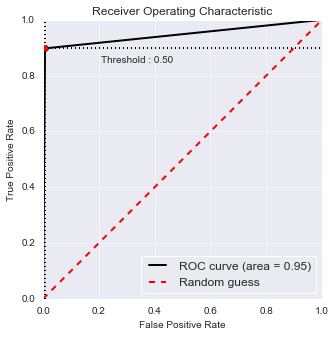

In [127]:
# evaluar desempeño del modelo
model_evaluation(data_train, label_train, data_test, label_test, model, label_pred)

In [128]:
# cargar el mejor modelo guardado durante el entrenamiento
saved_model = load_model('classification_model.h5')

In [129]:
# predecir etiquetas de clase con el mejor modelo guardado
label_pred2=saved_model.predict_classes(data_test)

Confusion Matrix: 
 [[12547   117]
 [   28   304]]


MEDIDAS DE DESEMPEÑO DEL MODELO


Exactitud - Accuracy: 0.9888427208371807
ROC AUC: 0.9532119317446666
------------------------------------------------------------
Precisión por clase: [0.99777336 0.72209026]
Sensibilidad - Recall por clase: [0.99076121 0.91566265]
F1 por clase: [0.99425492 0.80743692]
------------------------------------------------------------
F1 Macro: 0.9008459209637143
F1 Micro: 0.9888427208371807
F1 Weighted: 0.9894824100627577
------------------------------------------------------------
Sensibilidad - Recall Macro: 0.9532119317446666
Sensibilidad - Recall Micro: 0.9888427208371807
Sensibilidad - Recall Weighted: 0.9888427208371807
------------------------------------------------------------
Precisión Macro: 0.8599318105618072
Precisión Micro: 0.9888427208371807
Precisión Weighted: 0.9907306706503299
------------------------------------------------------------
Verdaderos positivos - True Positives: 304
Verdader

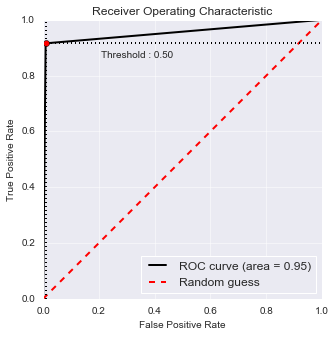

In [130]:
# evaluar desempeño del modelo
model_evaluation(data_train, label_train, data_test, label_test, saved_model, label_pred2)

## Evaluacion estabilidad de modelo

Se ejecutaran multiples entrenamientos del modelo seleccionado esto debido a la naturaleza estocastica de los modelos DNN para los mismos datos de entrenamiento

In [ ]:
# modelo

features =data_train.shape[2]
time_steps =data_train.shape[1]
weight = [{0:1,1:5}]

model = Sequential()
model.add(LSTM(70, input_shape=(time_steps, features), return_sequences=True,kernel_initializer='glorot_normal'))
model.add(Dropout(0.4))
model.add(LSTM(30, kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01), return_sequences=False))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

# fitting
history = model.fit(data_train, label_train, epochs=30, batch_size=64, validation_split=0.1, verbose=0, class_weight=weight,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path_clf, monitor='val_loss', save_best_only=True, mode='min', verbose=1)])
print(history.history.keys())



Train on 18477 samples, validate on 2054 samples
Epoch 1/30
 - 44s - loss: 2.0069 - acc: 0.9256 - val_loss: 0.1428 - val_acc: 0.9572
Epoch 2/30
 - 41s - loss: 0.1303 - acc: 0.9587 - val_loss: 0.1225 - val_acc: 0.9576
Epoch 3/30
 - 41s - loss: 0.1108 - acc: 0.9642 - val_loss: 0.0973 - val_acc: 0.9625
Epoch 4/30
 - 41s - loss: 0.1051 - acc: 0.9657 - val_loss: 0.0769 - val_acc: 0.9684
Epoch 5/30
 - 41s - loss: 0.0989 - acc: 0.9690 - val_loss: 0.1062 - val_acc: 0.9611
Epoch 6/30
 - 41s - loss: 0.0946 - acc: 0.9694 - val_loss: 0.0853 - val_acc: 0.9698
Epoch 7/30
 - 41s - loss: 0.0886 - acc: 0.9712 - val_loss: 0.0934 - val_acc: 0.9601
Epoch 8/30
 - 41s - loss: 0.0839 - acc: 0.9736 - val_loss: 0.0872 - val_acc: 0.9645
Epoch 9/30
 - 41s - loss: 0.0811 - acc: 0.9745 - val_loss: 0.1338 - val_acc: 0.9513
Epoch 10/30
 - 41s - loss: 0.0823 - acc: 0.9740 - val_loss: 0.0933 - val_acc: 0.9601
Epoch 11/30
 - 41s - loss: 0.0789 - acc: 0.9742 - val_loss: 0.0791 - val_acc: 0.9674
Epoch 12/30
 - 41s - loss

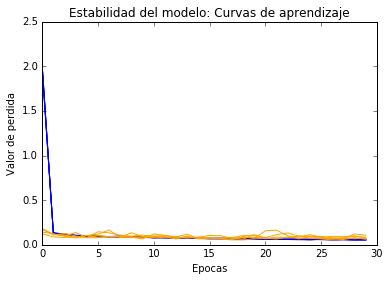

In [17]:
# adquirir datos de 5 repeticiones
from keras import regularizers

train = DataFrame()
val = DataFrame()
features =data_train.shape[2]
time_steps =data_train.shape[1]
weight = [{0:1,1:5}]

for i in range(5):
     # definir modelo
    model = Sequential()
    model.add(LSTM(70, input_shape=(time_steps, features), return_sequences=True,kernel_initializer='glorot_normal'))
    model.add(Dropout(0.4))
    model.add(LSTM(30, kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01), return_sequences=False))
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # entrenar modelo
    history = model.fit(data_train, label_train, epochs=30, batch_size=64, validation_split=0.1, verbose=2)
    # almacenar historia de perdida
    train[str(i)] = history.history[ 'loss' ]
    val[str(i)] = history.history[ 'val_loss' ]
    
# graficar perdida de entrenamiento y validacion en las multiples repeticiones
pyplot.plot(train, color= 'blue' , label= 'train' )
pyplot.plot(val, color= 'orange' , label= 'validation' )
pyplot.title( 'Estabilidad del modelo: Curvas de aprendizaje' )
pyplot.ylabel( 'Valor de perdida' )
pyplot.xlabel( 'Epocas' )
pyplot.show()

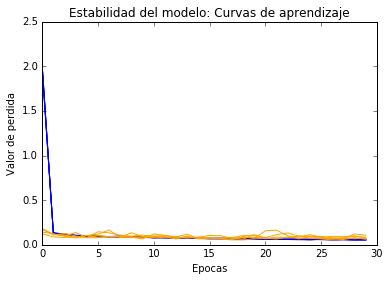

In [18]:
# exportar grafica

pyplot.plot(train, color= 'blue' , label= 'train' )
pyplot.plot(val, color= 'orange' , label= 'validation' )
pyplot.title( 'Estabilidad del modelo: Curvas de aprendizaje')
pyplot.ylabel( 'Valor de perdida' )
pyplot.xlabel( 'Epocas' )
plt.savefig('stacked4.png')
pyplot.show()

En la grafica se muestra multiples ejecuciones de diagnostico para los mismos datos de entrenamiento, con esta grafica se deduce que el modelo es estable y tiene un comportamiento solido a lo largo del tiempo.

## Curvas de aprendizaje y metricas de desempeño del modelo

In [13]:
model_path_clf = 'classification_model.h5'  

from keras import regularizers

features =data_train.shape[2]
time_steps =data_train.shape[1]
weight = [{0:1,1:5}]

model = Sequential()
model.add(LSTM(70, input_shape=(time_steps, features), return_sequences=True,kernel_initializer='glorot_normal'))
model.add(Dropout(0.4))
model.add(LSTM(30, kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01), return_sequences=False))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

# fitting
history = model.fit(data_train, label_train, epochs=40, batch_size=64, validation_split=0.1, verbose=2, class_weight=weight,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path_clf, monitor='val_loss', save_best_only=True, mode='min', verbose=1)])
print(history.history.keys())





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 40, 70)            26600     
_________________________________________________________________
dropout_1 (Dropout)          (None, 40, 70)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30)                12120     
_________________________________________________________________
dropout_2 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 31        
Total params: 38,751
Trainable params: 38,751
Non-trainable

In [132]:
def history_plot(hist1, hist2, title, ylabl, xlabl):
    fig_acc = plt.figure(figsize=(12,4))
    plt.plot(history.history[hist1])
    plt.plot(history.history[hist2])
    plt.title(title)
    plt.ylabel(ylabl)
    plt.xlabel(xlabl)
    plt.legend(['train', 'validation'], loc='upper left')
    return plt

<module 'matplotlib.pyplot' from 'C:\\Users\\alexh\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

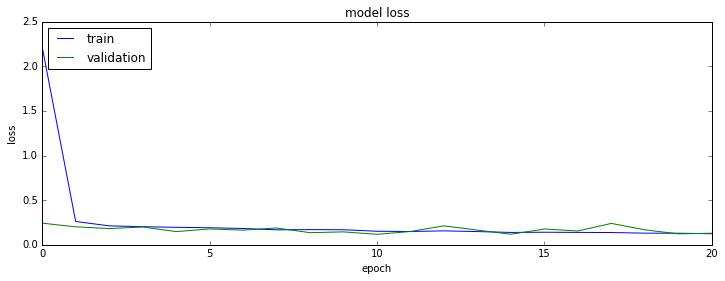

In [14]:

history_plot('loss', 'val_loss', 'model loss', 'loss', 'epoch')

La curva de aprendizaje del modelo apilado el cual fue configurado con la estructura optima, el resultado final es un ajuste adecuado, esto se puede diagnosticar ya que la perdida del conjunto de entrenamiento y la perdida del conjunto de validacion disminuyen y se estabilizan alrededor del mismo punto

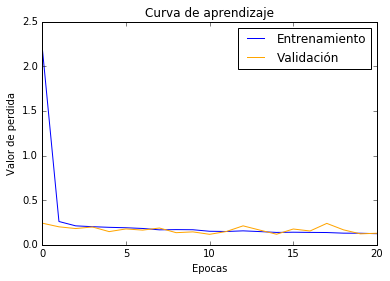

In [19]:
fig_acc = plt.figure(figsize=(6,4))
plt.plot(history.history['loss'], color= 'blue')
plt.plot(history.history['val_loss'],color= 'orange' )
plt.title('Curva de aprendizaje')
plt.ylabel('Valor de perdida')
plt.xlabel('Epocas')
plt.legend(['Entrenamiento', 'Validación'], loc='upper right')
plt.savefig('stacked5.png')
pyplot.show()

In [134]:
# evaluar el modelo en base de entrenamiento y prueba
_, train_acc = model.evaluate(data_train, label_train, verbose=1)
_, test_acc = model.evaluate(data_test, label_test, verbose=1)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

12996/12996 [==============================] - 30s 2ms/step
Train: 0.961, Test: 0.985


In [135]:
label_pred=model.predict_classes(data_test)

Confusion Matrix: 
 [[12491   173]
 [   21   311]]


MEDIDAS DE DESEMPEÑO DEL MODELO


Exactitud - Accuracy: 0.9850723299476762
ROC AUC: 0.9615431086316207
------------------------------------------------------------
Precisión por clase: [0.99832161 0.64256198]
Sensibilidad - Recall por clase: [0.98633923 0.93674699]
F1 por clase: [0.99229425 0.7622549 ]
------------------------------------------------------------
F1 Macro: 0.8772745752257052
F1 Micro: 0.9850723299476762
F1 Weighted: 0.986417589284108
------------------------------------------------------------
Sensibilidad - Recall Macro: 0.9615431086316206
Sensibilidad - Recall Micro: 0.9850723299476762
Sensibilidad - Recall Weighted: 0.9850723299476762
------------------------------------------------------------
Precisión Macro: 0.8204417973621356
Precisión Micro: 0.9850723299476762
Precisión Weighted: 0.9892332612667654
------------------------------------------------------------
Verdaderos positivos - True Positives: 311
Verdadero

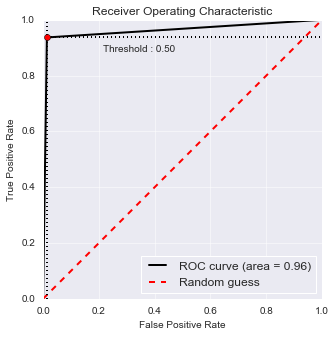

In [136]:
# metricas de desempeño:
model_evaluation(data_train, label_train, data_test, label_test, model, label_pred)

In [137]:
# cargar el mejor modelo guardado durante el entrenamiento

saved_model = load_model('classification_model.h5')

In [138]:
label_pred2=saved_model.predict_classes(data_test)

Confusion Matrix: 
 [[12552   112]
 [   39   293]]


MEDIDAS DE DESEMPEÑO DEL MODELO


Exactitud - Accuracy: 0.9883810403200985
ROC AUC: 0.9368430766654743
------------------------------------------------------------
Precisión por clase: [0.99690255 0.72345679]
Sensibilidad - Recall por clase: [0.99115603 0.88253012]
F1 por clase: [0.99402099 0.79511533]
------------------------------------------------------------
F1 Macro: 0.8945681591860715
F1 Micro: 0.9883810403200985
F1 Weighted: 0.9889396780819704
------------------------------------------------------------
Sensibilidad - Recall Macro: 0.9368430766654743
Sensibilidad - Recall Micro: 0.9883810403200985
Sensibilidad - Recall Weighted: 0.9883810403200985
------------------------------------------------------------
Precisión Macro: 0.8601796697817665
Precisión Micro: 0.9883810403200985
Precisión Weighted: 0.9899170160380204
------------------------------------------------------------
Verdaderos positivos - True Positives: 293
Verdader

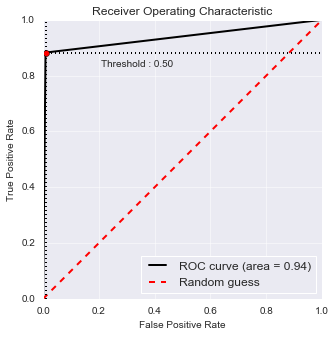

In [139]:
# metricas de desempeño del mejor modelo guardado Stacked LSTM 
model_evaluation(data_train, label_train, data_test, label_test, saved_model, label_pred2)

Este es el modelo LSTM apilado seleccionado por su desempeño en terminos de F1 macro y Recall de la clase minoritaria